# Cancer Detection
#### Description
We use a Deep U-net architecture to make a pix2pix mapping, taking images of cells to labeled images, marking the cancerous part of the cell in white.

In [1]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
import torchvision
from tqdm import tqdm
from torch.autograd import Variable
 
assert torch.cuda.is_available() # You need to request a GPU from Runtime > Change Runtime Type

from torch.nn.parameter import Parameter
import pdb
import os
import gzip
import tarfile
import gc
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

import PIL.Image

def register_extension(id, extension):
  PIL.Image.EXTENSION[extension.lower()] = id.upper()
PIL.Image.register_extension = register_extension

def register_extensions(id, extensions):
  for extension in extensions:
    register_extension(id, extension)
PIL.Image.register_extensions = register_extensions

class CancerDataset(Dataset):
  def __init__(self, root, download=True, size=512, train=True):
    if download and not os.path.exists(os.path.join(root, 'cancer_data')):
      datasets.utils.download_url('http://liftothers.org/cancer_data.tar.gz', root, 'cancer_data.tar.gz', None)
      self.extract_gzip(os.path.join(root, 'cancer_data.tar.gz'))
      self.extract_tar(os.path.join(root, 'cancer_data.tar'))
 
    postfix = 'train' if train else 'test'
    root = os.path.join(root, 'cancer_data', 'cancer_data')
    self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'inputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))
    self.label_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'outputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))
    self.train = train
    
  @staticmethod
  def extract_gzip(gzip_path, remove_finished=False):
    print('Extracting {}'.format(gzip_path))
    with open(gzip_path.replace('.gz', ''), 'wb') as out_f, gzip.GzipFile(gzip_path) as zip_f:
      out_f.write(zip_f.read())
    if remove_finished:
      os.unlink(gzip_path)
 
  @staticmethod
  def extract_tar(tar_path):
    print('Untarring {}'.format(tar_path))
    z = tarfile.TarFile(tar_path)
    z.extractall(tar_path.replace('.tar', ''))
 
  def __getitem__(self,index):
    img = self.dataset_folder[index]
    label = self.label_folder[index]
    return img[0] * 255,label[0][0]
 
  def __len__(self):
    if self.train:
      return 200
      return len(self.dataset_folder)
    else:
      return 10

In [0]:
class TwoConv2d(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(TwoConv2d, self).__init__()
    
    self.conv2d = nn.Sequential(nn.Conv2d(in_channels, out_channels, (3, 3), padding=(1,1)),
                         nn.ReLU(),
                         nn.Conv2d(out_channels, out_channels, (3, 3), padding=(1,1)),
                         nn.ReLU(),
                         nn.BatchNorm2d(out_channels)                         
                        )
    
  def forward(self, x):
    return self.conv2d(x)
  
class Upsample(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(Upsample, self).__init__()
    
    self.upsample = nn.Sequential(nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1),
                                   nn.ReLU()
                                  )
  def forward(self, x):
    return self.upsample(x)

class DeepUNetwork(nn.Module):
  def __init__(self, dataset):
    super(DeepUNetwork, self).__init__()
    x, y = dataset[0]
    c, h, w = x.size()
    output = 2  # number of final output channels
    
    self.conv1 = TwoConv2d(c, 64)
    self.conv2 = TwoConv2d(64, 128)
    self.conv3 = TwoConv2d(128, 256)
    self.conv4 = TwoConv2d(256, 512)
    self.conv5 = TwoConv2d(512, 1024)
    self.conv6 = TwoConv2d(1024, 512)
    self.conv7 = TwoConv2d(512, 256)
    self.conv8 = TwoConv2d(256, 128)
    self.conv9 = TwoConv2d(128, 64)
    self.conv10 = nn.Conv2d(64, output, (1, 1), padding=(0,0))

    self.transpose_conv1 = Upsample(1024, 512)
    self.transpose_conv2 = Upsample(512, 256)
    self.transpose_conv3 = Upsample(256, 128)
    self.transpose_conv4 = Upsample(128, 64)
    
    self.max_pool = nn.MaxPool2d(2)
    
  def forward(self, x):
    gc.collect()
    torch.cuda.empty_cache()
    x_layer1 = self.conv1(x) # Output 64x512x512 Captures low-level features
    x_layer2 = self.conv2(self.max_pool(x_layer1))   # Output 128x256x256
    x_layer3 = self.conv3(self.max_pool(x_layer2))   # Output 256x128x128. This is the most feature-rich layer, capturing high level features
    x_layer8 = self.conv8(torch.cat((x_layer2, self.transpose_conv3(x_layer3)), 1)) # Output 128x256x256
    x_layer9 = self.conv9(torch.cat((x_layer1, self.transpose_conv4(x_layer8)), 1)) # Output 64x512x512
    x_layer10 = self.conv10(x_layer9)
    return x_layer10

def compute_accuracy(model, data_loader):
  accuracies = [((model(x.cuda()).argmax(dim=1, keepdim=True)) - y_truth.cuda().long()).cpu().numpy().sum() / torch.numel(y_truth) for x, y_truth in data_loader]
  avg_acc = np.mean(accuracies)
  return avg_acc
  
def scope(epochs=100, train_size='small'):
#   try:
  #your code for calling dataset and dataloader
  train_dataset = CancerDataset('/tmp/mycancerdata')
  val_dataset = CancerDataset('/tmp/mycancerdata', train=False)
  gc.collect()
  mem = torch.cuda.memory_allocated(0) / 1e9

  model = DeepUNetwork(train_dataset).cuda()
  objective = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=1e-4)

  train_loader = DataLoader(train_dataset,  # You can change the way that your batch is shuffled
                         batch_size=1,   # You can also spin up multiple workers to work on multiple threads
                         shuffle=True,
                         pin_memory=True)
  val_loader = DataLoader(val_dataset,
                         shuffle=True,
                         batch_size=1,
                         pin_memory=True)

  train_losses = []
  validation_losses = []
  accuracies = []
  loop = tqdm(total=len(train_loader) * epochs, position=0)
  
  gc.collect()
  torch.cuda.empty_cache()
  
  for epoch in range(epochs):
    batch = 0
    
    for batch, (x, y_truth) in enumerate(train_loader):
      
      x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)

      optimizer.zero_grad()
      y_hat = model(x)
      accuracy = (y_hat.argmax(dim=1) == y_truth.long()).float().mean()
      
      loss = objective(y_hat, y_truth.long())
      
      loop.set_description('loss:{:.4f}, accuracy:{:.4f}.'.format(loss.item(), accuracy)) # loss.item() returns the simple float loss, not the entire loss tensor
      loop.update(1)
      loss.backward() # Compute the gradient for each weight with respect to the loss
      optimizer.step() # Take a step in the direction of the negative gradient
      
      if batch % 20 == 0:
        
        train_losses.append(loss.item())
        accuracies.append(accuracy)

        val_loss = np.mean([objective(model(val_x.cuda(async=True)), val_y_truth.cuda(async=True).long()).item() for val_x, val_y_truth in val_loader])
        validation_losses.append((len(validation_losses), val_loss))
        y_hat = np.argmin(y_hat.detach().squeeze().cpu().numpy(), axis=0)
      batch += 1

  
  loop.close()
  a, b = zip(*validation_losses)

  fig, axes = plt.subplots(1, 2, figsize=(15, 10))
  axes[0].plot(a, b, label='Validation Loss')
  axes[0].plot(a, train_losses, label='Training Loss')
  axes[0].set_title('Training and Validation Loss over Batches of Training')
  axes[0].set_xlabel('Batch')
  axes[0].set_ylabel('Loss')
  axes[0].legend()
  axes[1].plot(range(len(accuracies)), accuracies)
  axes[1].set_title('Accuracy over Batches of Training')
  axes[1].set_xlabel('Batch')

  plt.show()
      
  x_example, _ = val_dataset[172]
  y_hat = model(x_example.cuda(async=True).unsqueeze(0)).detach().squeeze().cpu().numpy() # Unsqueeze to add a dimension for batch, because that's what conv expects
  y_hat = np.argmin(y_hat, axis=0)
#   x_example = x_example.numpy().swapaxes(0,1).swapaxes(1,2).astype(np.float64)
  plt.imshow(y_hat, interpolation='nearest')
  plt.rcParams["axes.grid"] = False
  plt.show()

# Marked images during training, loss, accuracy, final marking of test image

loss:0.6351.:   0%|          | 1/1342 [00:00<13:59,  1.60it/s]

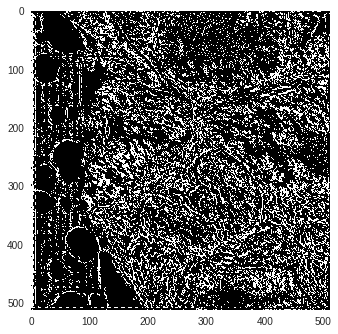

loss:0.6047.:   4%|▍         | 51/1342 [00:42<15:54,  1.35it/s]

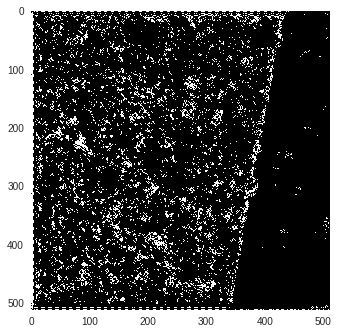

loss:0.5940.:   8%|▊         | 101/1342 [01:24<15:22,  1.35it/s]

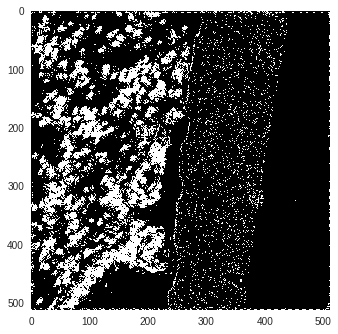

loss:0.5420.:  11%|█▏        | 151/1342 [02:06<14:38,  1.36it/s]

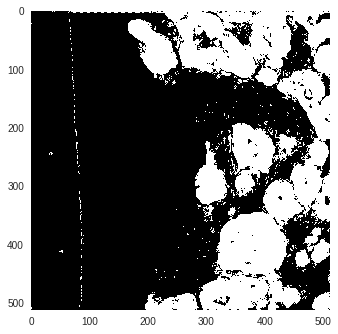

loss:0.5665.:  15%|█▍        | 201/1342 [02:47<14:04,  1.35it/s]

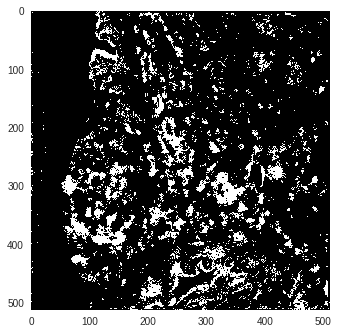

loss:0.5537.:  19%|█▊        | 251/1342 [03:29<13:23,  1.36it/s]

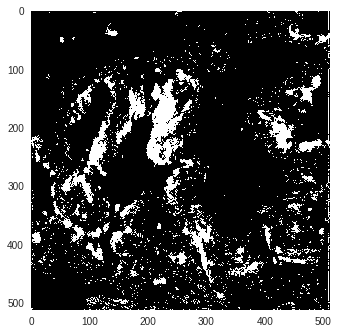

loss:0.5313.:  22%|██▏       | 301/1342 [04:11<12:52,  1.35it/s]

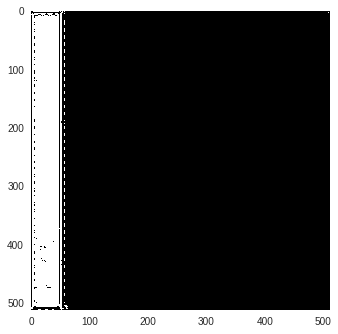

loss:0.5207.:  26%|██▌       | 351/1342 [04:53<12:09,  1.36it/s]

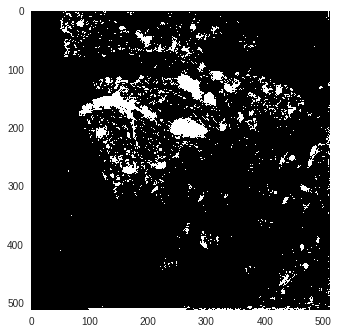

loss:0.4961.:  30%|██▉       | 401/1342 [05:34<11:36,  1.35it/s]

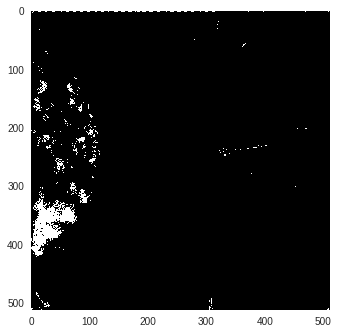

loss:0.5150.:  34%|███▎      | 451/1342 [06:16<10:58,  1.35it/s]

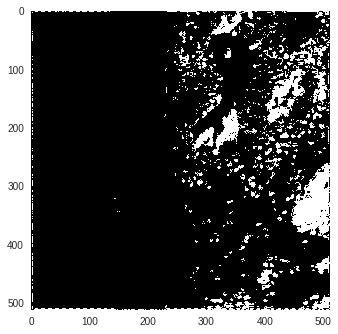

loss:0.5365.:  37%|███▋      | 501/1342 [06:58<10:22,  1.35it/s]

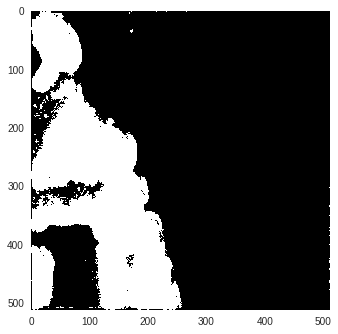

loss:1.0325.:  41%|████      | 551/1342 [07:40<09:46,  1.35it/s]

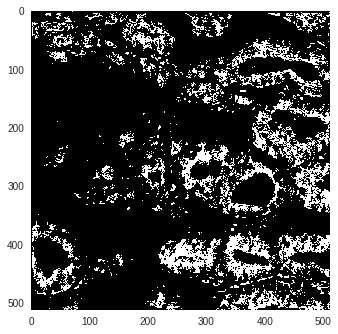

loss:0.4381.:  45%|████▍     | 601/1342 [08:21<09:04,  1.36it/s]

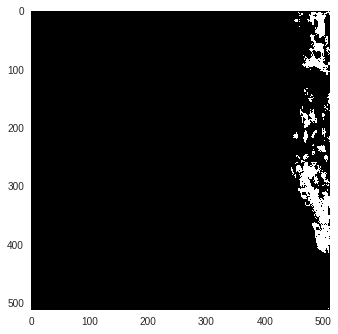

loss:0.4177.:  49%|████▊     | 651/1342 [09:03<08:29,  1.36it/s]

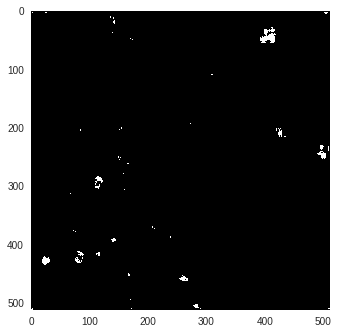

loss:0.4061.:  52%|█████▏    | 701/1342 [09:45<07:46,  1.37it/s]

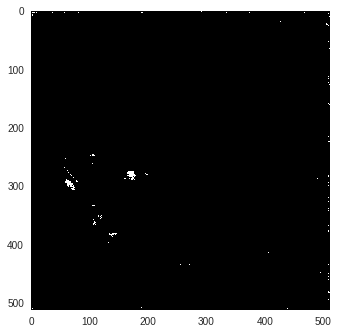

loss:0.4318.:  56%|█████▌    | 751/1342 [10:27<07:13,  1.36it/s]

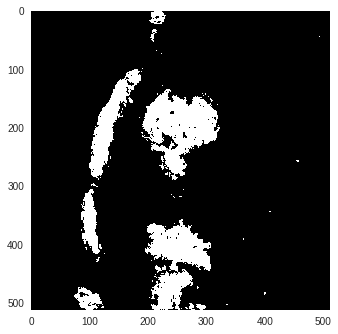

loss:0.6861.:  60%|█████▉    | 801/1342 [11:08<06:38,  1.36it/s]

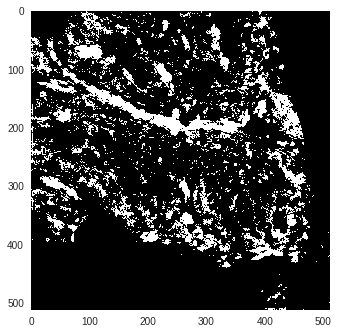

loss:0.3634.:  63%|██████▎   | 851/1342 [11:50<06:02,  1.35it/s]

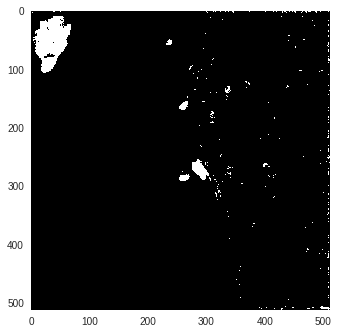

loss:0.3571.:  67%|██████▋   | 901/1342 [12:32<05:23,  1.36it/s]

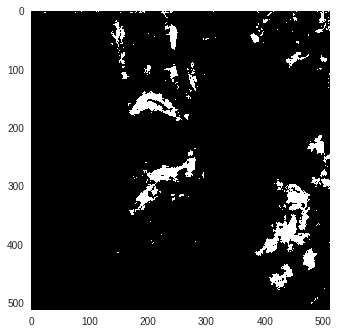

loss:0.3305.:  71%|███████   | 951/1342 [13:13<04:48,  1.36it/s]

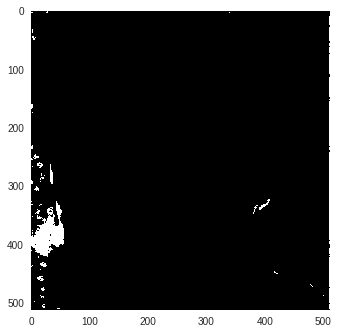

loss:0.1771.:  75%|███████▍  | 1001/1342 [13:55<04:11,  1.36it/s]

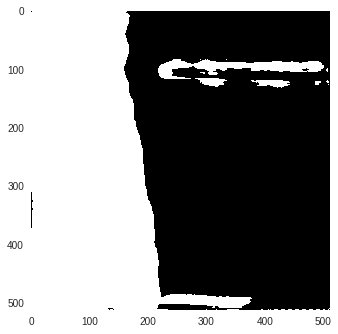

loss:0.3073.:  78%|███████▊  | 1051/1342 [14:37<03:33,  1.36it/s]

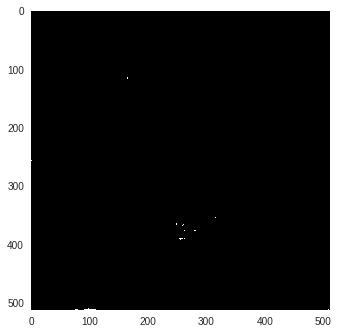

loss:0.2920.:  82%|████████▏ | 1101/1342 [15:18<02:56,  1.36it/s]

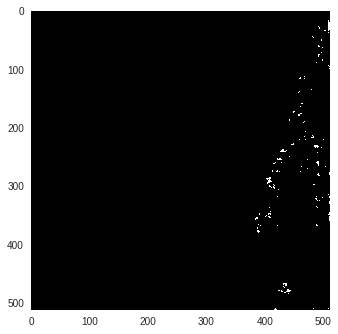

loss:0.4621.:  86%|████████▌ | 1151/1342 [16:00<02:20,  1.36it/s]

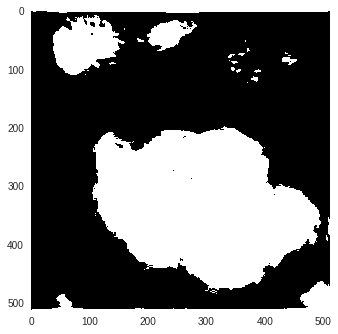

loss:0.2637.:  89%|████████▉ | 1201/1342 [16:41<01:43,  1.36it/s]

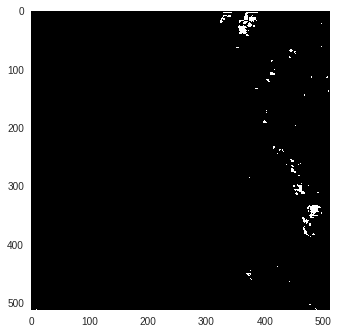

loss:0.2536.:  93%|█████████▎| 1251/1342 [17:23<01:06,  1.36it/s]

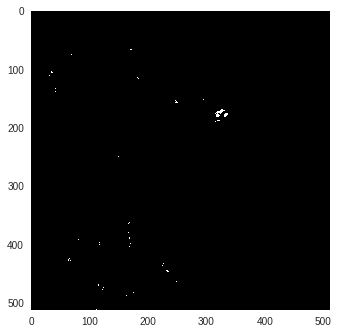

loss:0.2366.:  97%|█████████▋| 1301/1342 [18:05<00:30,  1.36it/s]

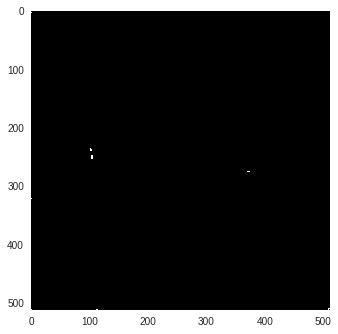

loss:0.2723.: 100%|██████████| 1342/1342 [18:40<00:00,  1.36it/s]


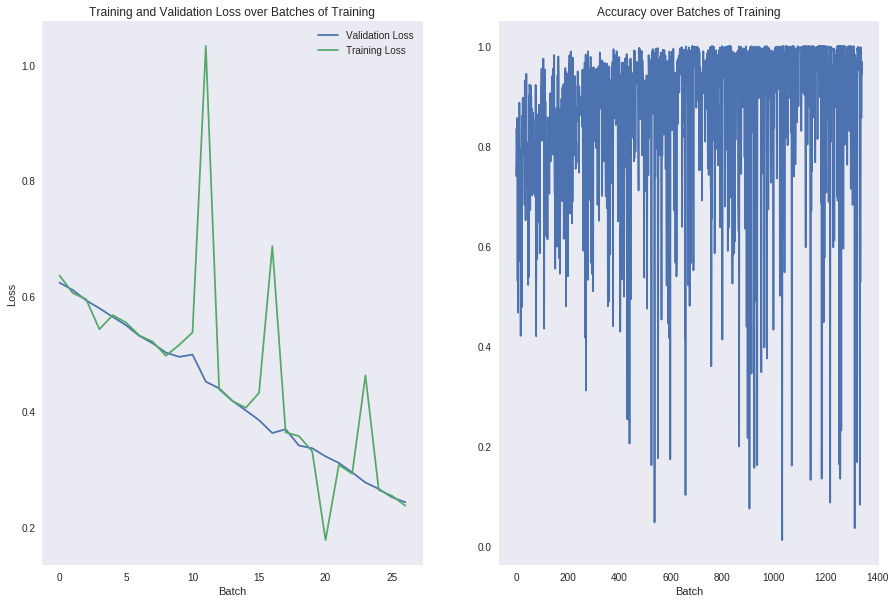

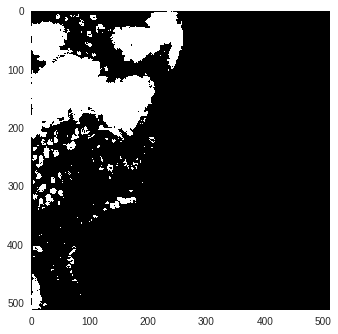

In [299]:
scope(epochs=1)